In [52]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.io.wavfile import read
import IPython.display as ipd
from pathlib import Path
import requests
from tqdm import tqdm
from scipy.io import loadmat

In [32]:
def prototyp(L):
    a=np.zeros(7)
    a0=1; 
    a[0]=-0.99998229
    a[1]=0.99692250
    a[3]=1/np.sqrt(2)
    a[5]=np.sqrt(1-a[1]**2)
    a[6]=-np.sqrt(1-a[0]**2)
      
    A=-(a0/2+a[0]+a[1]+a[2]+a[3]+a[5]+a[6])
    
    a[2]=A/2-np.sqrt(0.5-(A**2)/4)
    a[4]=-np.sqrt(1-a[2]**2)
   
    n=np.arange(L)
    p = a0*np.ones((1,L));
    
    for k in range(len(a)):
        p+=2*a[k]*np.cos(2*np.pi*(k+1)*n/L)
    
    p = p/L
    p[:,0]=0
        
    
    return p.T


In [33]:
M=32 # liczba kanałów,
L=512 # długość filtra prototypowego
p=prototyp(L)

In [34]:
#analysis

def analysis_filters(M,p):
    
    Lp=len(p)
    h=np.zeros((M,Lp))
    
        
    for n in range(Lp):
        for k in range(M):
            h[k,n]=2*p[n] *np.cos(  (np.pi/M) *(k+0.5) * (n -(Lp-1)/2)+ np.pi/4*((-1)**k)  ) 

    
    
    return h


#synthesis    
def synthesis_filters(M,p):
    
    Lp=len(p)
    g=np.zeros((M,Lp))
                   
    for n in range(Lp):
        for k in range(M):
            g[k,n]=2*p[n] *np.cos(  (np.pi/M) *(k+0.5) * (n -(Lp-1)/2) -np.pi/4*((-1)**k)  ) 
    
    return g

h=analysis_filters(M,p)
g=synthesis_filters(M,p)

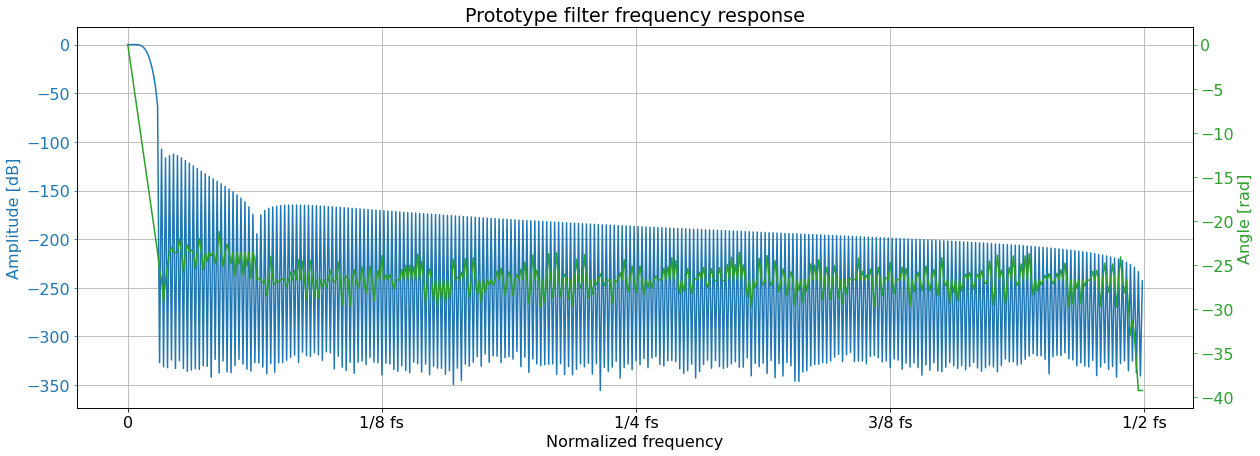

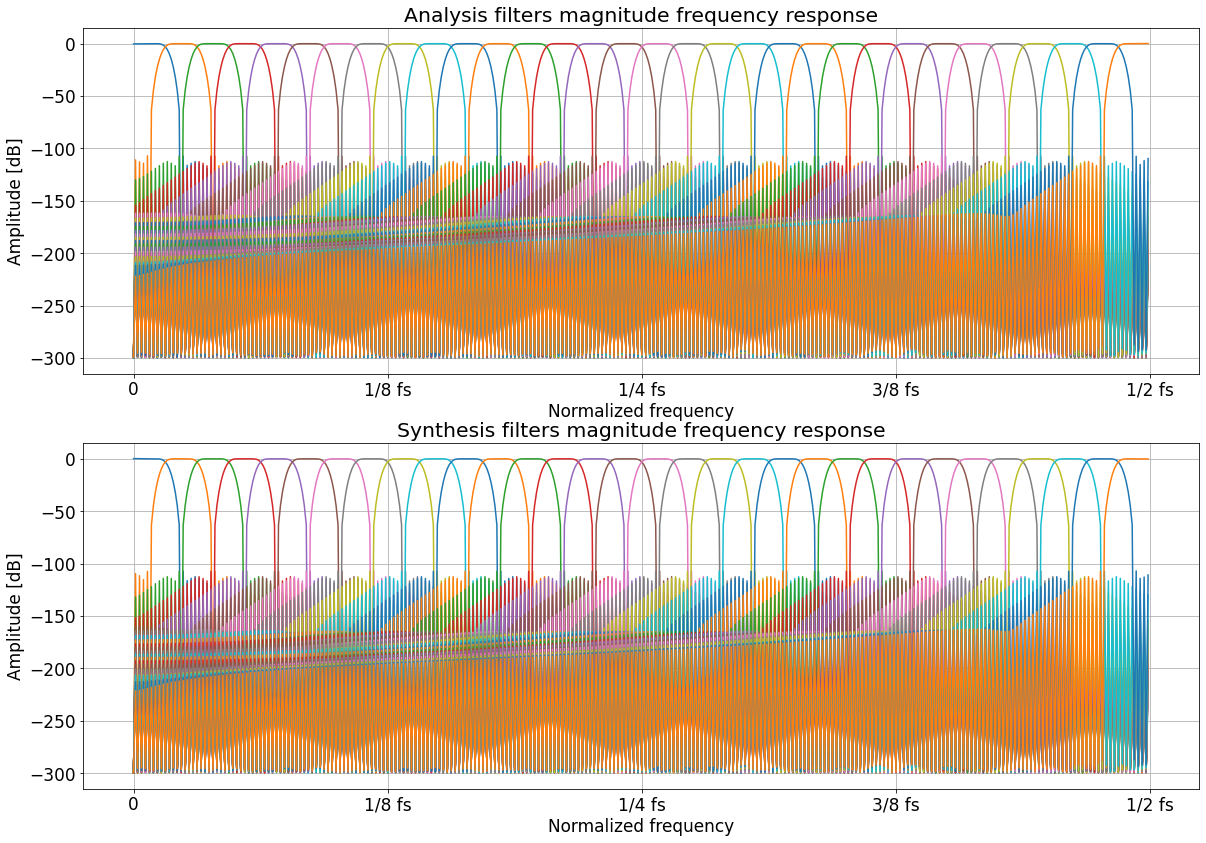

In [35]:
_, P = scipy.signal.freqz(p)
angles = np.unwrap(np.angle(P))


plt.rc('font', size=16)
fig, ax = plt.subplots(figsize=(20, 7))

ax.plot(20*np.log10(abs(P)), '#1f77b4')
ax.grid()
ax.set_title('Prototype filter frequency response')
ax.set_xlabel('Normalized frequency')
ax.set_ylabel('Amplitude [dB]', color='#1f77b4')
ax.tick_params(axis='y', colors='#1f77b4')
ax.set_xticks([0, len(P)/4, len(P)/2, 3*len(P)/4, len(P)])
ax.set_xticklabels(['0', r'1/8 fs', '1/4 fs', '3/8 fs', '1/2 fs'])

ax2 = ax.twinx()
ax2.plot(angles, '#2ca02c')
ax2.set_ylabel('Angle [rad]', color='#2ca02c')
ax2.tick_params(axis='y', colors='#2ca02c')

fig.show()


plt.rc('font', size=17)

fig, ax = plt.subplots(2, 1, figsize=(20, 14))

for k in range(M):
    _, H = scipy.signal.freqz(h[k])
    ax[0].plot(20*np.log10(abs(H)+1e-15), label='$H_{}$'.format(k))
ax[0].grid()
ax[0].set_title('Analysis filters magnitude frequency response')
ax[0].set_xlabel('Normalized frequency')
ax[0].set_ylabel('Amplitude [dB]')

if M < 10:
    ax[0].legend()
ax[0].set_xticks([0, len(H)/4, len(H)/2, 3*len(H)/4, len(H)])
ax[0].set_xticklabels(['0', r'1/8 fs', '1/4 fs', '3/8 fs', '1/2 fs'])

for k in range(M):
    w, G = scipy.signal.freqz(g[k])
    ax[1].plot(20*np.log10(abs(G)+1e-15), label='$G_{}$'.format(k))
ax[1].grid()
ax[1].set_title('Synthesis filters magnitude frequency response')
ax[1].set_xlabel('Normalized frequency')
ax[1].set_ylabel('Amplitude [dB]')

if M < 10:
    ax[1].legend()
ax[1].set_xticks([0, len(G)/4, len(G)/2, 3*len(G)/4, len(G)])
ax[1].set_xticklabels(['0', r'1/8 fs', '1/4 fs', '3/8 fs', '1/2 fs'])
    
plt.show()

In [36]:


def downsample(x, K, t=None):
    
    y_K = x[::K] 
    if t is None:
        return y_K
    else:
        t_K = t[::K]
        return y_K, t_K
    
def upsample(x, L, t=None):
    y_L=np.zeros((len(x)*L))
    y_L[0:len(y_L):L]=x
    if t is None:
        return y_L
    dt=t[2]-t[1]
    dtL=dt/(L)
    t_L=np.arange(0, max(t)+L*dtL, dtL)
    
    return y_L, t_L


In [37]:
def analysis(x,h,M):
    
    Nh = h.shape[1] 
    Nx = x.shape[0]  
    
    N_filter = np.maximum(Nh, Nx)  
    y = np.zeros((M, N_filter))
    
    for i in range(M):
        y[i]=np.convolve(h[i,:],x,'same')
    
    
    y_0=np.zeros((M,y.shape[1]//M +1))
    for i in range(M):
        y_0[i,:]=downsample(y[i,:],32)
        
    return y_0


def synthesis(y_0,g,M):
    N=y_0.shape[1]
    y_L=np.zeros((M,N*M))
    
    for i in range(M):
        y_L[i,:]=upsample(y_0[i,:],32)
    
    
    y=np.zeros((M,N*M))
    for i in range(M):
        
        y[i,:]=np.convolve(g[i,:],y_L[i,:],'same')
        
    y = np.sum(y, axis=0)
    return y





In [38]:
def download(url, path):
    if not isinstance(path, Path):
        path = Path(path)
    if not path.is_file():
        r = requests.get(url)
        with open(path, "wb") as f:
            f.write(r.content)
            
urls = {
    "epic_sax_guy_single_channel.wav": "http://sp-class.agh.edu.pl/samples/epic_sax_guy_single_channel.wav",
    "lenna.png": "http://sp-class.agh.edu.pl/samples/lenna.png",
}

for filename, url in tqdm(urls.items()):
    download(url, filename)
    
    
    


100%|██████████| 2/2 [00:00<00:00, 3855.06it/s]


In [50]:
fs, x = read('epic_sax_guy_single_channel.wav')  # this is a single-channel version
print("oryginalny plik audio")
display(ipd.Audio(data=x, rate=fs))


print("po przejsciu przez filerbank bez korekty")
Y_synthesis=synthesis(analysis(x,h,M),g,M) #po przejsciu przez filerbank ale bez zmiany podpasm
display(ipd.Audio(data=Y_synthesis, rate=fs))



#wzmocnienie i osłabienie poszczególnych pasm
y_0=analysis(x,h,M)
for i in range(y_0.shape[1]):
    if i >=0 and i < 1 :
        y_0[i,:]=40*y_0[i,:]
    elif i >=14 and i <= 15:
        y_0[i,:]=30*y_0[i,:]
    elif i>=7 and i<9 :
        y_0[i,:]=0.1*y_0[i,:]
    
    
    
    
y=synthesis(y_0,g,M)

print("po przejsciu przez filerbank z korektą")
display(ipd.Audio(data=y, rate=fs))

print(fs)



oryginalny plik audio


po przejsciu przez filerbank bez korekty


po przejsciu przez filerbank z korektą


44100


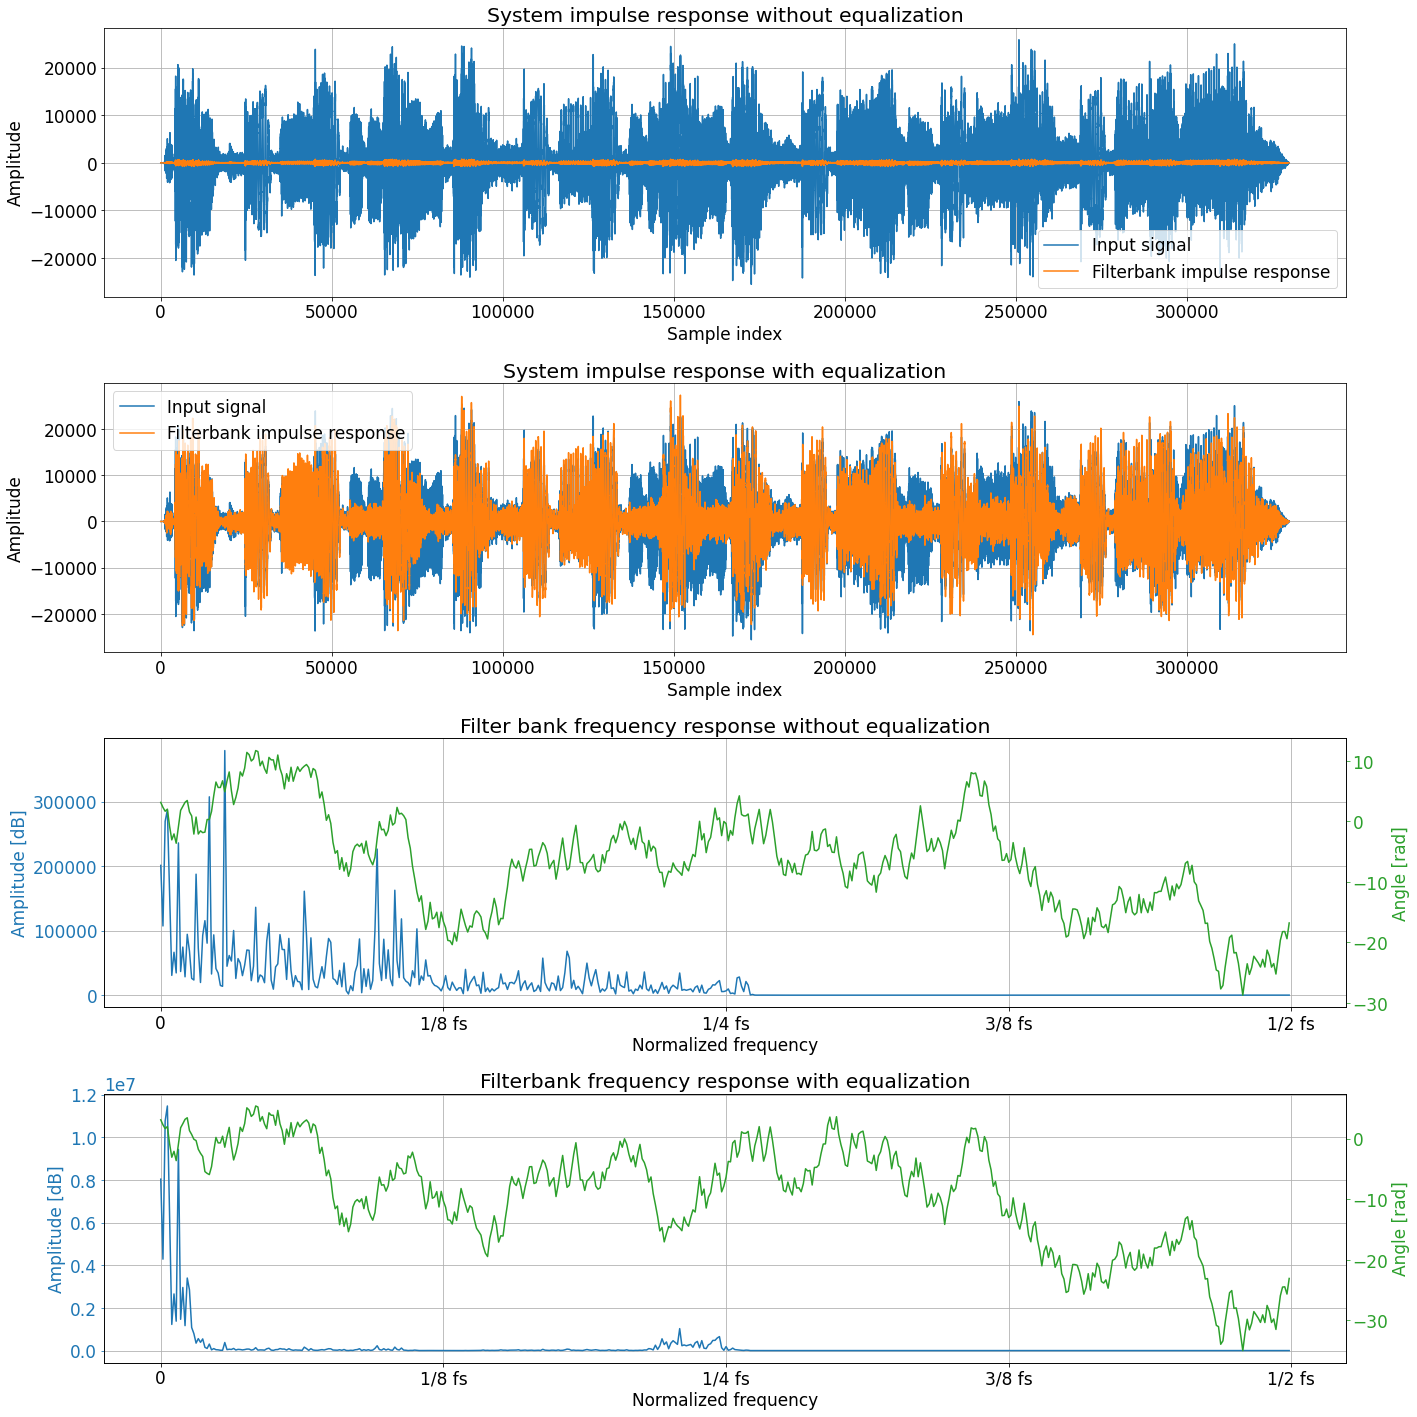

In [55]:

fig,axes=plt.subplots(nrows=4,ncols=1,figsize=(20,20))

axes[0].plot(x, label='Input signal')
axes[0].plot(Y_synthesis,label='Filterbank impulse response')
axes[0].set_title('System impulse response without equalization')
axes[0].set_xlabel('Sample index')
axes[0].set_ylabel('Amplitude')
axes[0].grid()
axes[0].legend()








axes[1].plot(x, label='Input signal')
axes[1].plot(y, label='Filterbank impulse response')
axes[1].set_title('System impulse response with equalization')
axes[1].set_xlabel('Sample index')
axes[1].set_ylabel('Amplitude')
axes[1].grid()
axes[1].legend()

_, X = scipy.signal.freqz(Y_synthesis)
angles = np.unwrap(np.angle(X))

axes[2].plot(np.abs(X))
axes[2].set_title('Filter bank frequency response without equalization')
axes[2].set_xlabel('Normalized frequency')
axes[2].set_ylabel('Amplitude [dB]', color='#1f77b4')
axes[2].tick_params(axis='y', colors='#1f77b4')
axes[2].set_xticks([0, len(P)/4, len(P)/2, 3*len(P)/4, len(P)])
axes[2].set_xticklabels(['0', r'1/8 fs', '1/4 fs', '3/8 fs', '1/2 fs'])
axes[2].grid()


axes[2] = axes[2].twinx()
axes[2].plot(angles,'#2ca02c')
axes[2].set_ylabel('Angle [rad]', color='#2ca02c')
axes[2].tick_params(axis='y', colors='#2ca02c')
axes[2].set_xticks([0, len(P)/4, len(P)/2, 3*len(P)/4, len(P)])
axes[2].set_xticklabels(['0', r'1/8 fs', '1/4 fs', '3/8 fs', '1/2 fs'])


_, Y = scipy.signal.freqz(y)
angles = np.unwrap(np.angle(Y))

axes[3].plot(np.abs(Y))
axes[3].set_title('Filterbank frequency response with equalization')
axes[3].set_xlabel('Normalized frequency')
axes[3].set_ylabel('Amplitude [dB]', color='#1f77b4')
axes[3].tick_params(axis='y', colors='#1f77b4')
axes[3].set_xticks([0, len(P)/4, len(P)/2, 3*len(P)/4, len(P)])
axes[3].set_xticklabels(['0', r'1/8 fs', '1/4 fs', '3/8 fs', '1/2 fs'])
axes[3].grid()


axes[3] = axes[3].twinx()
axes[3].plot(angles,'#2ca02c')
axes[3].set_ylabel('Angle [rad]', color='#2ca02c')
axes[3].tick_params(axis='y', colors='#2ca02c')
axes[3].set_xticks([0, len(P)/4, len(P)/2, 3*len(P)/4, len(P)])
axes[3].set_xticklabels(['0', r'1/8 fs', '1/4 fs', '3/8 fs', '1/2 fs'])

fig.tight_layout()
plt.show()

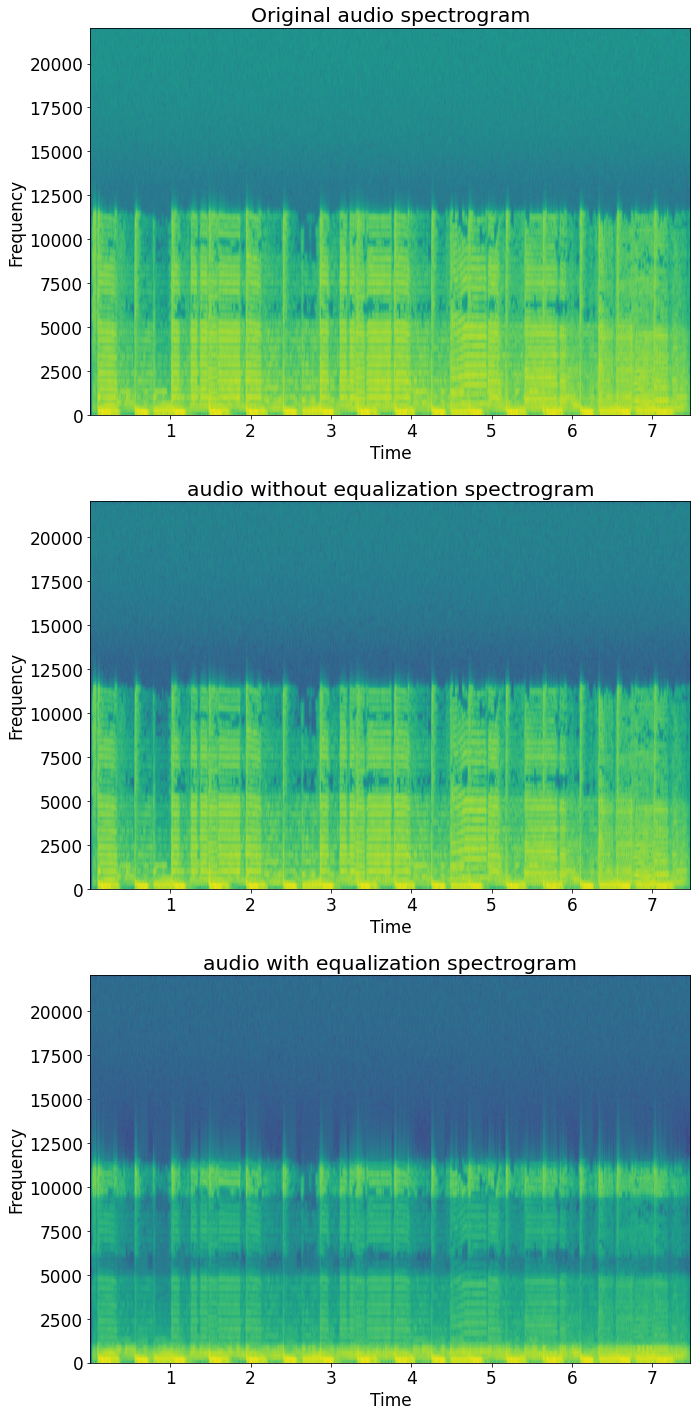

In [84]:
#spektrogramy

fig,axes=plt.subplots(nrows=3,ncols=1,figsize=(10,20))



axes[0].specgram(x,Fs=fs)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Original audio spectrogram')
                  
axes[1].specgram(Y_synthesis,Fs=fs)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Frequency')
axes[1].set_title('audio without equalization spectrogram')
                  
axes[2].specgram(y,Fs=fs)
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Frequency')
axes[2].set_title('audio with equalization spectrogram')

fig.tight_layout()
plt.show()












